# 03. 정밀도와 재현율
- 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.
- 정밀도 = TP / (FP+TP)
- 재현율 = TP / (FN+TP)
- 재현율이 중요 지표인 경우, 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생
    - ex)암 판단 모델, 보험사기, 금융 사기
- 정밀도가 더 중요한 지표인 경우, 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되어 업무상 큰 영향 발생
    - ex) 스팸 메일 판단
- 재현율과 정밀도 모두 TP를 높이는데 초점
- 재현율은 FN(실제 Positive,예측 Negative)를 낮추는 데, 정밀도는 FP를 낮추는데 초점
- 이러한 특성 때문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 적용

### 타이타닉 예제를 이용해 오차 행렬 및 정밀도, 재현율 구하기
- 사이킷런 제공 API
- 정밀도 : precision_score( )
- 재현율 : recall_score( )

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit()메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    #predict()메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i]==0
            else:
                pred[i]==1
        return pred
    
from sklearn.preprocessing import LabelEncoder
import numpy as np

#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features=['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [3]:
#로지스틱 회귀 기반으로 타이타닉 생존자 예측

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('Data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

#LogisticRegression 객체의 생성 인자로 입력되는 solver='liblinear'는 로지스틱 회귀의 최적화 알고리즘 유형을 지정
#작은 데이터 세트의 이진 분류인 경우 solver는 liblinear가 약간 성능이 좋은 경향이 있다.
#solver의 기본값은 lbfgs이며 데이터 세트가 상대적으로 크고 다중 분류인 경우 적합

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


### 정밀도/재현율 트레이드오프
- 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.
- 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.
- 이를 정밀도/재현율의 트레이드오프(Trade-off)라 한다.
- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다. 그리고 예측 확률이 큰 레이블 값으로 예측하게 된다.
- 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba( )를 제공한다.
- predict_proba( )메서드는 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하며 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환한다.

In [4]:
#이진 분류에서 predict_proba()를 수행해 반환되는 ndarray는 첫 번째 칼럼이 클래스 값 0에 대한 예측 확률, 두 번째 칼럼이 클래스 값 1에 대한 예측 확률
pred_proba = lr_clf.predict_proba(X_test)
print('pred_proba( )결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:',pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba( )결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


- ndarray는 0과 1에 대한 확률을 나타내므로 첫 번째 칼럼 값과 두 번째 칼럼 값을 더하면 1이 된다.
- 맨 마지막 줄의 predict( )메서드의 결과 비교에서도 나타나듯이, 두 개의 칼럼 중에서 더 큰 확률 값으로 predict( )메서드가 최종 예측하고 있음
- predict( )메서드는 predict_proba( )메서드에 기반해 생성된 API이다.
- predict( )는 predict_proba( ) 호출 결과로 반환된 배열엥서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API이다.

### 사이킷런의 정밀도/재현율 트레이드오프 방식 이해하기

In [5]:
#Binarizer 클래스 : threshold보다 작거나 같으면 0, 크면 1을 반환
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


- 입력된 X 데이터 세트에서 Binarizer의 threshold 값이 1.1보다 같거나 작으면 0, 크면 1로 반환

In [6]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


In [7]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197


- 임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어짐
- 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 된다.

In [8]:
# 임곗값에 따른 정확도, 정밀도, 재현율 비교
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도:0.8547, 정밀도:0.7869, 재현율:0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도:0.8715, 정밀도:0.8654, 재현율:0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도:0.8771, 정밀도:0.8980, 재현율:0.7213


- precision_recall_curve( ) API : 임곗값 변화에 따른 평가 지표

In [10]:
#precision_recall_curve() API를 이용한 평가 지표
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape: ', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값 : ',np.round(thresholds[thr_index],2))

#15 Step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:',np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:',np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape:  (147,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 :  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도: [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


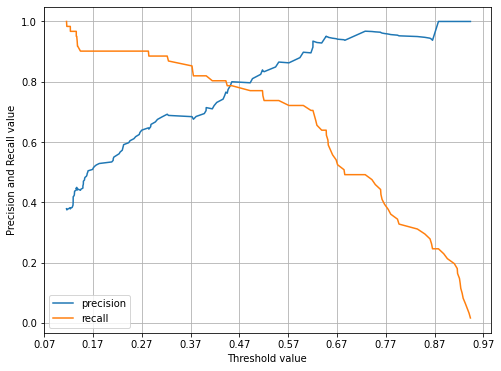

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    #threshold 값 X축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    #X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 정밀도와 재현율의 맹점
- Postivie 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다.
- 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다.

**정밀도가 100%가 되는 방법**
- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
- 전체 환자 1000명 중 확실한 Positive 징후만 가진 환자는 단 1명이라고 가정하면, 한명만 Positive로 예측하고 나머지는 모두 Negative로 예측

**재현율이 100%가 되는 방법**
- 모든 환자를 Postivie로 예측  

정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능하다. 따라서 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

# 04. F1스코어
- 정밀도와 재현율을 결합한 지표
<img src="https://user-images.githubusercontent.com/63237947/104834091-9c1d0c00-58e0-11eb-99ea-c6bb341cb820.png"></img>

- 사이킷런 F1 스코어를 구현하기 위한 f1_score( ) API 제공

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 score : {0:.4f}'.format(f1))

F1 score : 0.7966


In [15]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # f1 score 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197, F1:0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도:0.8547, 정밀도:0.7869, 재현율:0.7869, F1:0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705, F1:0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도:0.8715, 정밀도:0.8654, 재현율:0.7377, F1:0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도:0.8771, 정밀도:0.8980, 재현율:0.7213, F1:0.8000


# 05. ROC곡선과 AUC
- ROC곡선과 이에 기반한 AUC스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이다.
- ROC곡선(Receiver Operation Characteristic Curve)
- 의학 분야에 많이 사용되지만, 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요 평가 지표이기도 하다.
- FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선
- FPR = FP / (FP+TN) = 1 - TNR = 1- 특이성
- TPR은 재현율(민감도)을 나타낸다. TPR = TP / (FN+TP) : 실제값 Positive(양성)가 정확히 예측돼야 하는 수준을 나타낸다.
- TNR(True Negative Rate) = 특이성(Specificity). TNR = TN / (FP+TN) : 실제값 Negative(음성)가 정확히 예측돼야 하는 수준을 나타낸다.
- ROC곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구한다.
- 분류 결정 임곗값을 변경함으로써 FPR을 0부터 1까지 변경
- 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이기 때문에 FPR을 0으로 만들려면 임곗값을 1로 지정하면 된다.
- 임곗값을 1로 지정하면 Positive 예측 기준이 매우 높기 때문에 분류기(Classifier)가 임곗값보다 높은 확률을 가진 데이터를 Positive로 예측할 수 없다.
- FPR을 0으로 만드려면 TN을 0으로 만들면 된다.
- TN을 0으로 만드려면 임곗값을 0으로 지정하면 된다. 그러면 분류기의 Postivie 확률 기준이 너무 낮아서 다 Positive로 예측한다.
- 사이킷런은 ROC곡선을 구하기 위해 roc_curve( ) API를 제공

In [17]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index:',thr_index)
print('샘플 index로 추출한 임곗값:',np.round(thresholds[thr_index],2))

#5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


- 임겟값이 작아질수록 FPR값 증가
- FPR이 조금씩 커질 때 TPR은 가파르게 커짐

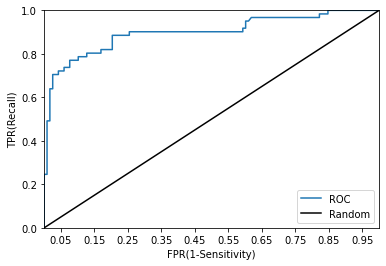

In [18]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],'k-',label='Random')
    
    #FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

- 일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하며 분류의 성능 지표로 사용되는 것은 ROC곡선 면적에 기반한 AUC값으로 결정한다.
- AUC(Area Under Curve)값은 ROC곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치이다.
- AUC수치가 커지려면 FPR값이 작고 TPR값이 커야 한다.

In [20]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


In [24]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f},F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705,F1:0.7966, AUC:0.8987
